# Replication: Shu *et al*, 2020
## Introduction

This notebook attempts to replicate the following paper with the [PPMI](http://ppmi-info.org) dataset:

<div class="alert alert-block alert-success">
Shu, Zhen‐Yu, et al. <a href="https://onlinelibrary.wiley.com/doi/full/10.1002/mrm.28522?casa_token=Ab53WvMlODcAAAAA%3AXcgDLmq8egqW7uwd2g3jY9jIljhLu3VhIbvMWgbcfoWOxjO_9H7Arf91t2FBZDZ8E94Je4Wmrn0ZmkeZ">Predicting the progression of Parkinson's disease using conventional MRI and machine learning: An application of radiomic biomarkers in whole‐brain white matter.</a> Magnetic Resonance in Medicine 85.3 (2021): 1611-1624.</div>

This study recruited 72 patients with progressive PD and 72 patients with stable PD matched by age, sex and category of HYS. The objective of the study is to develop and validate a radiomics model to predict the progression of Parkinson disease. This following population from PPMI was used:

<img src="./images/table.png" width="80%"/>

The main results show that the the areas under curve of the radiomics model reaches 0.795 which suggests that the use of a simple radiomics signature built from whole-brain white matter can be a useful tool for the assessment and monitoring of PD progression

<img src="./images/result.png" width="30%"/>

The remainder of this notebook is an attempt to replicate this result using the PPMI dataset.

## Initial setup

Let's initialize the notebook dependencies:

In [1]:
import livingpark_utils

utils = livingpark_utils.LivingParkUtils('shu-etal')
utils.notebook_init()
# random_seed = 1 # to be tested
random_seed = 2  # no significant cluster
# random_seed = 3 # no significant cluster
# random_seed = 4 # no significant cluster

removing link inputs
removing link outputs
Installing notebook dependencies (see log in install.log)... 
This notebook was run on 2022-08-25 13:20:32 UTC +0000


## PPMI cohort preparation

We will build a PPMI cohort that matches the one used in the original study (Table 1) as much as possible. As in other LivingPark replications, we will use the same sample size as the original study. Our cohort will be built directly from PPMI Study Data files so that it can be replicated and updated whenever necessary.

### Study data download

We will start by downloading the PPMI Study Data files required to build our cohort: 
* Age at visit (this could also be retrieved from imaging data)
* Demographics (to retrieve sex)
* Participant Status (to retrieve PD patients)

We will use the LivingPark utils library to download these files from the notebook. If files are already present in the notebook cache, they won't be downloaded again. Otherwise, you will need to enter your PPMI username and password. In case you don't have a PPMI account, you can request one [here](http://ppmi-info.org).

In [2]:
required_files = [
    'Age_at_visit.csv', 
    'Demographics.csv', 
    'Participant_Status.csv'
]

utils.download_ppmi_metadata(required_files)

Download skipped: No missing files!


### Additional data

We will also need `MRI_info.csv` and `MDS_UPDRS_Part_III_clean.csv` that are produced by another LivingPark notebook available at https://github.com/LivingPark-MRI/ppmi-MRI-metadata and https://github.com/LivingPark-MRI/ppmi-treatment-and-on-off-status respectively. 

The `MRI_info.csv` file contains a list usable T1-weighted MRIs. This is important since the original study uses  T1-weighted MRIs from PPMI. Therefore, we need to filter out all other scanners. The `MDS_UPDRS_Part_III_clean.csv` file is a refined version of PPMI's UPDRS III data.

File downloaded
['COR', 'Coronal', 'Cal Head 24', 'Transverse', 'tra_T1_MPRAGE', 'TRA']
['AX', 'axial', 'Phantom']
{'Screening': 'SC', 'Baseline': 'BL', 'Month 12': 'V04', 'Month 24': 'V06', 'Month 36': 'V08', 'Month 48': 'V10', 'Symptomatic Therapy': 'ST', 'Unscheduled Visit 01': 'U01', 'Unscheduled Visit 02': 'U02', 'Premature Withdrawal': 'PW'}
Saved in MRI_info.csv
This notebook was run on 2022-08-25 13:20:32 UTC +0000
File downloaded


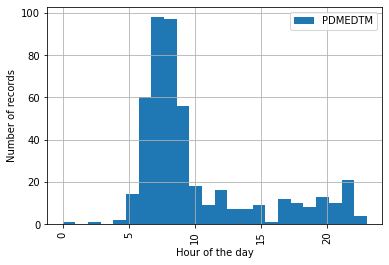

Removed 40 records where PDSTATE=ON and EXAMTM<PDMEDTM
Number of removed records: 5
Found 0 records in Case 3.a
Removed 1 record(s) with missing EXAMTM or PDMEDTM
Cleaned file saved in MDS_UPDRS_Part_III_clean.csv
True


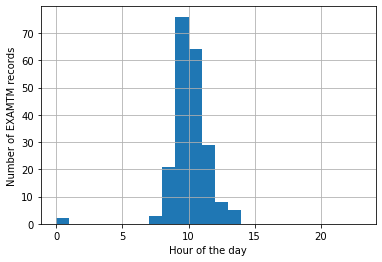

In [3]:
# Import notebooks and execute

from livingpark_utils.scripts import (
    mri_metadata,
    pd_status
)

## Hoehn & Yahr stage

The first dataframe required will be extracted from `MDS_UPDRS_Part_III_clean.csv` with the objective to select a group of patients that are off medication during examination.

In [4]:
import os
import pandas as pd

# Define data directory for additional data
data_dir = "data"

# Load PPMI UPDRS III data (modified)
df_hy = pd.read_csv(
    os.path.join(data_dir, 'MDS_UPDRS_Part_III_clean.csv')
)

# Keep patients OFF medication
df_hy = df_hy[df_hy["PDSTATE"]=="OFF"]

# Drop unnecessary columns
keep_cols = ['EVENT_ID', 'PATNO', 'NHY', 'PDSTATE', 'PDTRTMNT']
df_hy = df_hy.drop([x for x in df_hy.columns if x not in keep_cols], axis=1)

# Display number of patients
df_hy.groupby('PDSTATE').count()

,PATNO,EVENT_ID,NHY,PDTRTMNT
PDSTATE,,,,
OFF,12979,12979,12972,12979


## Demographics

Needed for sex. (0: Female, 1: Male)

In [5]:
# Load PPMI Demographics data
demo = pd.read_csv(
    os.path.join(utils.study_files_dir, 'Demographics.csv')
)

# Drop useless columns
keep = ['PATNO', 'SEX']
demo = demo.drop([x for x in demo.columns if x not in keep], axis=1)

# Convert data to 0/1 values
demo['SEX'] = demo['SEX'].astype(int)

# Show sex stats (0: Female, 1: Male)
demo.groupby('SEX').count()

,PATNO
SEX,
0,993
1,1350


There is a decent balance between the number of males and females.

## Age at visit

Needed for age.

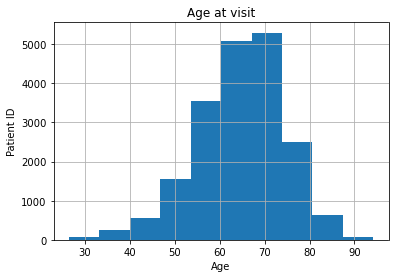

In [6]:
import matplotlib.pyplot as plt

# Load PPMI age data
df_age = pd.read_csv(
    os.path.join(utils.study_files_dir, 'Age_at_visit.csv')
)

# Show histogram
df_age['AGE_AT_VISIT'].hist()

# Histogram settings
plt.title('Age at visit')
plt.xlabel('Age')
plt.ylabel('Patient ID');

Our histogram suggests that the majority of patients are between the ages of 60 and 72.

## MRI availability

The study performed contains patients evaluted over the course of 3 years and classifies the patients into progression and stable groups. The `MRI_info.csv` has information on every patient and every single visit. We filter out patients that do not have 3 year of visit history.

In [7]:
import numpy as np

# Load MRI info data
mri_df = pd.read_csv(
    os.path.join(data_dir, 'MRI_info.csv')
)

# Keep rows with visits we need
# We need a 3-year gap between visits so the only possible pairs are the following ones:
visits = {'BL': 'V08', 
          'V04': 'V10',
          'V06': 'V12',
          'V08': 'V13',
          'V10': 'V14'}

mri_df.rename(columns={'Subject ID': 'PATNO', 'Visit code': 'EVENT_ID'}, inplace=True)
mri_df = mri_df[mri_df['EVENT_ID'].isin(visits)]
mri_df["PATNO"] = mri_df["PATNO"].astype(np.int64)
mri_df["Description"] = mri_df["Description"].astype(str)

# Show pairs formed
mri_df.groupby('EVENT_ID').count()

,PATNO,Sex,Visit,Age,Description
EVENT_ID,,,,,
BL,1153,1153,1153,1153,1153
V04,274,274,274,274,274
V06,324,324,324,324,324
V08,2,2,2,2,2
V10,357,357,357,357,357


## Participant status

Since this study is revolved around patients with Parkinson's disease, this will help filter out all other patients.

In [8]:
# Read CSV | 1: PD, 2: Cohort
participant_df = pd.read_csv(
    os.path.join(utils.study_files_dir, 'Participant_Status.csv')
)

# Keep useful columns
participant_df = participant_df[["PATNO", "COHORT_DEFINITION"]]
participant_df = participant_df[participant_df["COHORT_DEFINITION"]=="Parkinson's Disease"]

# Display stats
participant_df.groupby('COHORT_DEFINITION').count()

,PATNO
COHORT_DEFINITION,
Parkinson's Disease,1153


## Merge all dataframes together

Before performing cohort matching, we need to build one final dataframe that consists of all the data we just extracted.

In [9]:
# keys = ['PATNO', 'EVENT_ID']

df_mri_age = df_age.merge(mri_df, how='right')
df_mri_age['AGE_AT_VISIT'].fillna(df_mri_age['Age'])
df_mri_age = df_mri_age.merge(participant_df, on="PATNO")

df = df_hy.merge(df_mri_age, how='inner')

# Display patients per HY stage
df.groupby('NHY').count()

,PATNO,EVENT_ID,PDSTATE,PDTRTMNT,AGE_AT_VISIT,Sex,Visit,Age,Description,COHORT_DEFINITION
NHY,,,,,,,,,,
1,242,242,242,242,242,242,242,242,242,242
2,602,602,602,602,602,602,602,602,602,602
3,36,36,36,36,36,36,36,36,36,36
4,6,6,6,6,6,6,6,6,6,6
UR,1,1,1,1,1,1,1,1,1,1


## Format data by visit pairs

Finally, we form the data such that each row contains a patients' data from both visits.

In [10]:
def next_visit(x):
    return visits[x]

In [11]:
visits_df = df

# Set id of second visit in pair
visits_df['next_visit'] = visits_df['EVENT_ID'].apply(next_visit)

# Retrieve H&Y score of next visit
visits_df = visits_df.merge(df_hy, how='left', left_on=['PATNO', 'next_visit'], right_on=['PATNO', 'EVENT_ID'])

# Add patient sex to visit pairs
visits_df = visits_df.merge(demo, on=['PATNO'])

# Define visit as stable if NHY (first visit)
visits_df['stable'] = (visits_df['NHY_x'] == visits_df['NHY_y'])

# Display data pairs
visits_df.groupby(['stable', 'NHY_x'], dropna=False).count()

PATNO  EVENT_ID_x  PDSTATE_x  PDTRTMNT_x  AGE_AT_VISIT  Sex  \
stable NHY_x                                                                
False  1        207         207        207         207           207  207   
       2        356         356        356         356           356  356   
       3         35          35         35          35            35   35   
       4          6           6          6           6             6    6   
       UR         1           1          1           1             1    1   
       NaN        1           1          1           1             1    1   
True   1         35          35         35          35            35   35   
       2        246         246        246         246           246  246   
       3          1           1          1           1             1    1   

              Visit  Age  Description  COHORT_DEFINITION  next_visit  \
stable NHY_x                                                           
False  1        207  207          207                207         207   
       2        356  356          356                356         356   
       3         35   35           35                 35          35   
       4          6    6            6                  6           6   
       UR         1    1            1                  1           1   
       NaN        1    1            1                  1           1   
True   1         35   35           35                 35          35   
       2        246  246          246                246         246   
       3          1    1            1                  1           1   

              EVENT_ID_y  PDSTATE_y  NHY_y  PDTRTMNT_y  SEX  
stable NHY_x                                                 
False  1             102        102    102         102  207  
       2              50         50     50          50  356  
       3               8          8      8           8   35  
       4               2          2      2           2    6  
       UR              0          0      0           0    1  
       NaN             0          0      0           0    1  
True   1              35         35     35          35   35  
       2             246        246    246         246  246  
       3               1          1      1           1    1

# Matching

We implemented a nearest-neighbor matching loop based on the Euclidean distance. We will match stable and progressive groups for age and sex for each H&Y value.

## Normalization

We need to normalize age or else it will dominate sex in the Euclidean distance.

In [12]:
df = visits_df
to_normalize = ['AGE_AT_VISIT'] 
for var in to_normalize:
    df[f'{var}_norm'] = (df[var] - df[var].mean())/df[var].std()
df.describe()

,PATNO,PDTRTMNT_x,AGE_AT_VISIT,Age,PDTRTMNT_y,SEX,AGE_AT_VISIT_norm
count,888.000000,888.000000,888.000000,888.000000,444.000000,888.000000,8.880000e+02
mean,22941.084459,0.444820,63.281982,63.294144,0.936937,0.650901,5.656761e-15
std,34868.683066,0.497226,9.527825,9.529679,0.243351,0.476954,1.000000e+00
min,3001.000000,0.000000,33.700000,33.700000,0.000000,0.000000,-3.104799e+00
25%,3357.750000,0.000000,56.625000,56.500000,1.000000,0.000000,-6.986885e-01
50%,3814.500000,0.000000,64.350000,64.350000,1.000000,1.000000,1.120946e-01
75%,40744.000000,1.000000,70.500000,70.500000,1.000000,1.000000,7.575725e-01
max,150505.000000,1.000000,86.300000,86.300000,1.000000,1.000000,2.415873e+00


## Matching loop

Nearest neighbor matching loop applied for each H&Y value to extract stable and progressive populations with matched sex and age.

In [13]:
def nn(x, df, matched_vars):
    '''
    Find index of nearest neighbor of x in df
    '''
    
    # Select only the subjects with the same H&Y score
    df_hy_match = df[df['NHY_x'] == x['NHY_x'].values[0]]
 
    # Compute squared distance between x and all elements in df, using normalized variables
    df_hy_match['dist'] = sum((df_hy_match[f'{var}']-x[f'{var}'].values[0])**2 for var in matched_vars)
    
    # Return the element in df with the smallest distance
    df_hy_match.sort_values('dist', inplace=True)
    return df_hy_match.head(1)  ## there's probably a better way to do it but it should work

def match(n, group1_df, group2_df, matched_vars):
    '''
    Randomly pick n elements in group1_df, then find n matching elements in group2_df.
    Ensure that each group only contains 1 or less element from each patient and that 
    no patient has elements in both groups.
    '''
    
    from numpy.random import choice, seed

    # Select n random patients in group1
    group1_patnos = sorted(pd.unique(group1_df['PATNO']))
    seed(0)  # change this to bootstrap population
    group1_patnos_sample = choice(group1_patnos, n, replace=False)
    
    # Remove the selected patients from group2
    for p in group1_patnos_sample:
        group2_df = group2_df[group2_df['PATNO']!=p]
    
    group1_matched = pd.DataFrame(columns=group1_df.columns)
    group2_matched = pd.DataFrame(columns=group1_df.columns)

    for p in group1_patnos_sample:  # for each patient in sampled list
        # Pick a random element from this patient in group1
        s = group1_df[group1_df['PATNO'] == p].sample(1)
        # Find the best match in group2
        t = nn(s, group2_df, matched_vars)
        # Add s and t to matched groups
        group1_matched = group1_matched.append(s)
        group2_matched = group2_matched.append(t)
        # Remove t's patient from group 2 so that it doesn't get selected again
        group2_df = group2_df[group2_df['PATNO']!=t['PATNO'].values[0]]
    
    return group1_matched, group2_matched

matched_vars = ['AGE_AT_VISIT_norm', 'SEX']

        
# Apply matching to get 29 patients with H&Y=1
stable1, progr1 = match(29,
                        df[(df['stable'] == True) & (df['NHY_x'] == "1")],
                        df[(df['stable'] == False) & (df['NHY_x'] == "1")],
                        matched_vars)
patids = pd.unique(pd.concat([stable1, progr1], axis=0)["PATNO"])
df_filtered = df[~df['PATNO'].isin(patids)]

# Apply matching to get 43 patients with H&Y=2
stable2, progr2 = match(43,
                        df_filtered[(df_filtered['stable'] == True) & (df_filtered['NHY_x'] == "2")],
                        df_filtered[(df_filtered['stable'] == False) & (df_filtered['NHY_x'] == "2")],
                        matched_vars)


In [14]:
stable = stable1.append(stable2)
progr = progr1.append(progr2)

## Sanity checks

In order to ensure that the cohort built meets the requirements, we ensure that:

1. Both groups have equal size

2. No patient is present more than once in each group

3. Patients in group A aren't in group B and vice versa

In [15]:
for (a, b) in [(stable1, progr1), (stable2, progr2)]:
    # Both groups have equal size
    assert(len(a) == len(b))
    # No patient is present more than once in each group
    for x in [a, b]:
        patnos_x = pd.unique(x['PATNO'])
        assert(len(patnos_x)==len(x)), x
    # Patients in a aren't in b
    patnos_a = pd.unique(a['PATNO'])
    patnos_b = pd.unique(b['PATNO'])
    for p in patnos_a:
        assert(p not in patnos_b), f'PATNO {p} appears in a and b'
        
# Patients in each cohort do not replicate
assert len(set(pd.unique(progr["PATNO"])) & (set(pd.unique(stable["PATNO"]))))==0, "Patients occur in both groups"

print('All good!')

All good!


## Cohort summary

In [16]:
cohort_stats = pd.DataFrame(columns=[f"Stable", f"Progression"])

cohort_stats.loc["Subjects, No."] = [len(stable), len(progr)]

cohort_stats.loc["F/M, No."] = [
    f"{len(stable[stable['SEX']==0])}/{len(stable[stable['SEX']==1])}",
    f"{len(progr[progr['SEX']==0])}/{len(progr[progr['SEX']==1])}",
]

cohort_stats.loc["Age, mean +/- SD"] = [
    f"{round(stable['Age'].mean(),1)} +/- {round(stable['Age'].std(),1)}",
    f"{round(progr['Age'].mean(),1)} +/- {round(progr['Age'].std(),1)}",
]

cohort_stats.loc["Hoehn & Yahr Stage 1 (n)"] = [
    f"{len(stable[stable['NHY_x']=='1'])}",
    f"{len(progr[progr['NHY_x']=='1'])}"
]

cohort_stats.loc["Hoehn & Yahr Stage 2 (n)"] = [
    f"{len(stable[stable['NHY_x']=='2'])}",
    f"{len(progr[progr['NHY_x']=='2'])}"
]

cohort_stats

,Stable,Progression
"Subjects, No.",72,72
"F/M, No.",26/46,26/46
"Age, mean +/- SD",60.9 +/- 8.9,61.0 +/- 8.8
Hoehn & Yahr Stage 1 (n),29,29
Hoehn & Yahr Stage 2 (n),43,43


The demographics of the replicated cohort are close enough to the original study. The goal was to match patients based on sex, age and initial H&Y stage. In the original study, the cohort built consists of 47 patients in stage 1 and 25 patients in stage 2. This could not be achieved since the UPDRS_III data file used in this replication was modified to only contain patients off medication during examination.